In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import dc_stat_think as dcst

In [2]:
subscription = pd.read_csv('subscription.csv')
display(subscription.head())
display(subscription.tail())

,user_id,subscription_signup_date,subscription_monthly_cost,country,source,billing_cycles,is_active
0,1459,"January, 2015",29,Spain,ads,4,0
1,12474,"January, 2015",49,France,ads,5,0
2,12294,"January, 2015",49,Germany,ads,2,0
3,3878,"January, 2015",49,China,ads,1,0
4,9567,"January, 2015",49,UK,ads,5,0


,user_id,subscription_signup_date,subscription_monthly_cost,country,source,billing_cycles,is_active
499995,496962,"January, 2015",29,Spain,ads,2,0
499996,480669,"January, 2015",29,Italy,seo,1,0
499997,491164,"January, 2015",29,UK,ads,2,0
499998,493323,"January, 2015",49,Germany,ads,1,0
499999,482977,"January, 2015",49,France,ads,5,0


In [3]:
subscription.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 7 columns):
 #   Column                     Non-Null Count   Dtype 
---  ------                     --------------   ----- 
 0   user_id                    500000 non-null  int64 
 1   subscription_signup_date   500000 non-null  object
 2   subscription_monthly_cost  500000 non-null  int64 
 3   country                    500000 non-null  object
 4   source                     500000 non-null  object
 5   billing_cycles             500000 non-null  int64 
 6   is_active                  500000 non-null  int64 
dtypes: int64(4), object(3)
memory usage: 26.7+ MB


Thoughts:
* No missing data
* `subscription_signup_date` is not necessary since we know for a fact that it's all January, 2015. For larger datast, use pandas profiling
* ~~Users could switch subscription (either upgrade or downgrade). I think these users should be handled separately. Let's now check that.~~

In [8]:
# check if there's any repeated user_id
np.any(subscription['user_id'].value_counts() > 1)

False

Thoughts:
* So we don't have any users who switched their subscription.
* ~~Next, regarding `is_active`. I feel this one is redundant. Ideally, `is_active` = 0 if users didn't have their eighth subscription. Let's check that~~

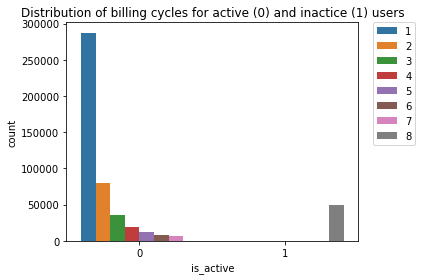

In [17]:
# distribution of billing cycles for active/inactive users
_ = sns.countplot(x='is_active', hue='billing_cycles', data=subscription)

# control legend
# Credit: https://stackoverflow.com/a/34579525/5158984. No idea how it works
_ = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
_ = plt.title('Distribution of billing cycles for active (0) and inactice (1) users')

# show the plot with tight layout
plt.tight_layout()
plt.show()

Thoughts:
* It's clear that users with 8 billing cycles or more are still active users.
* How can I write this sentence more coherently? Ask both book club.

# Compute the retention rate for each subscription price point

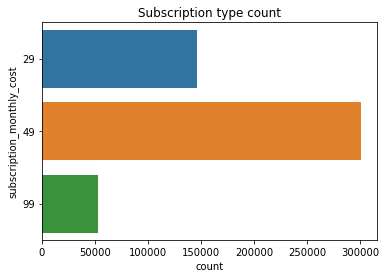

In [18]:
# quickly check the distribution of each subscription type
sns.countplot(y='subscription_monthly_cost', data=subscription)

_ = plt.title('Subscription type count')
plt.show()

Let's write a helper function to help us calculate the retention rate

In [21]:
# start with a toy data to test
toy_df = pd.DataFrame({'user_name': ['Huy', 'Garrett', 'Earl', 'Josh', 'Ted', 'Xi', 'Kayla', 'Aurora'], 
                       'billing_cycles': [1, 1, 1, 2, 2, 3, 3, 3]})
toy_df

,user_name,billing_cycles
0,Huy,1
1,Garrett,1
2,Earl,1
3,Josh,2
4,Ted,2
5,Xi,3
6,Kayla,3
7,Aurora,3


We expect the following subscription's survival rate:
* Month 1: 100%
* Month 2: $\frac{5}{8} = $ 62.5%. Explanation: the first three people stopped the subscription, and the rest still "survive" at month 2.
* Month 3: $\frac{3}{8} = $ 37.5%. Similar explanation as the above.

Now, we'll write a function to that gives this same results.

In [39]:
def calculate_survival_rate(df):
    """
    Calculate the survival rate of the users based on their billing cycles.
    """
    survival_rate = []
    billing_cycle_range = sorted(df['billing_cycles'].unique())
    number_of_participants = df.shape[0]
    
    for cycle in billing_cycle_range:
        number_of_survivors = np.sum(df['billing_cycles'] >= cycle)
        ratio = number_of_survivors / number_of_participants * 100
        survival_rate.append(ratio)
    
    return survival_rate

In [40]:
# Test
calculate_survival_rate(toy_df)

[100.0, 62.5, 37.5]

## Survival analysis for each subscription group

In [42]:
# calculate the survival rate for the $29 subscription group
subscription_29 = subscription[subscription['subscription_monthly_cost']==29]
subscription_29_sr = calculate_survival_rate(subscription_29)
subscription_29_sr

[100.0,
 60.75415749989751,
 45.84728276465203,
 37.62315355078504,
 32.30278350938085,
 28.541561334226095,
 25.715691231330535,
 23.590139517087767]

In [44]:
# calculate the survival rate for the $49 subscription group
subscription_49 = subscription[subscription['subscription_monthly_cost']==49]
subscription_49_sr = calculate_survival_rate(subscription_49)
subscription_49_sr

[100.0,
 38.36656158350449,
 20.62470663821543,
 13.404261693692016,
 9.64656770873211,
 7.407197808233771,
 5.940805001381505,
 4.884536130520611]

In [45]:
# calculate the survival rate for the $99 subscription group
subscription_99 = subscription[subscription['subscription_monthly_cost']==99]
subscription_99_sr = calculate_survival_rate(subscription_99)
subscription_99_sr

[100.0,
 15.876861817020718,
 7.00400067617062,
 4.241092391202269,
 2.9676377228076105,
 2.218215285212524,
 1.793730395747638,
 1.5007231269134689]

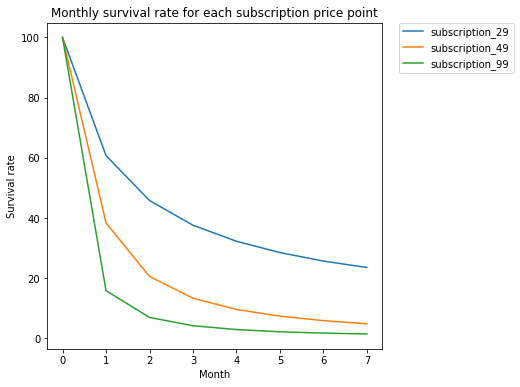

In [58]:
# plot
_ = plt.figure(figsize=(6, 6))
_ = plt.plot(subscription_29_sr)
_ = plt.plot(subscription_49_sr)
_ = plt.plot(subscription_99_sr)

_ = plt.title('Monthly survival rate for each subscription price point')
_ = plt.xlabel('Month')
_ = plt.ylabel('Survival rate')
#_ = plt.legend(['subscription_29', 'subscription_49', 'subscription_99'])
# _ = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.) # this doesn't work. need to ask StackOverflow

_ = plt.legend( ['subscription_29', 'subscription_49', 'subscription_99'], 
               bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.) # this works. I don't know why

plt.tight_layout
plt.show()

Thoughts:
* Users with highest subscription retention rate are the ones in the 29-dollar subscription plan, followed by 49-dollar and then 99-dollar.
    * This makes sense.
    * However, what's interesting is that the 49-dollar plan group had the most users subscribed to
* For prediction, maybe a regression is good enough.